## Classificação dos Dígitos 1 x 5 (Um-Contra-Um)

Na classificação *Um-Contra-Um* (One-vs-One), em vez de treinar um classificador para
cada classe contra todas as outras (*Um-Contra-Todos*), treinamos classificadores
binários **apenas entre dois dígitos de interesse**.  

No caso específico da tarefa **1 x 5**, o conjunto de treinamento é reduzido
para conter **apenas exemplos dos dígitos 1 e 5**.  
Assim, o problema deixa de ser multiclasse e passa a ser **binário**, onde:

- As amostras com rótulo **1** são mapeadas para a classe positiva (+1).  
- As amostras com rótulo **5** são mapeadas para a classe negativa (-1).  
### Estratégia
O procedimento para **1 x 5** é:
1. Selecionar apenas os exemplos dos dígitos 1 e 5 do dataset.  
2. Definir rótulos binários (+1 para o dígito 1, -1 para o dígito 5).  
3. Treinar um modelo linear (Perceptron, Regressão Logística, etc.) neste subconjunto.  
4. Avaliar o desempenho com métricas de classificação binária (acurácia, precisão, recall, F1-score).  

### Importação das bibliotecas

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### Classes e funções

#### Lista de pontos classificados incorretamente

In [122]:
def constroiListaPCI(X, y, w):
        l = []
        new_y = []
        for i in range(len(X)):
            pred = w[0]*1 + w[1]*X[i][0] + w[2]*X[i][1]
            pred = 1 if pred >= 0 else -1
            if pred != y[i]:
                l.append(X[i])
                new_y.append(y[i])
        return l, new_y

#### Perceptron

In [123]:
class PerceptronManual():
    def __init__(self, max_iter=1000):
        self.max_iter = max_iter
        self.w = None

    def execute(self, X, y):
        """
        Treina o Perceptron usando X (normalizado) e y (+1/-1)
        """
        X_list = X.tolist()  # compatível com PLA clássico
        y_list = y.tolist()

        self.w = [0.0, 0.0, 0.0]  # bias + pesos

        for it in range(self.max_iter):
            listaPCI, new_y = constroiListaPCI(X_list, y_list, self.w)

            if len(listaPCI) == 0:
                # todos os pontos classificados corretamente
                break

            # escolhe aleatoriamente um ponto mal classificado
            idx = random.randint(0, len(listaPCI)-1)
            x_pci = listaPCI[idx]
            y_pci = new_y[idx]

            # atualiza pesos
            self.w[0] += y_pci * 1        # bias
            self.w[1] += y_pci * x_pci[0]
            self.w[2] += y_pci * x_pci[1]

    def h(self, x):
        """
        Retorna a predição (+1/-1) para um vetor x (sem bias adicionado)
        """
        x_bias = np.array([1, *x])
        return np.sign(np.dot(self.w, x_bias))

#### Pocket perceptron

In [ ]:
class PocketPerceptron():
    def __init__(self, max_iter=1000):
        self.max_iter = max_iter
        self.w = None  # pesos finais

    def execute(self, X, y):
        X_list = X.tolist()
        y_list = y.tolist()

        self.w = [0.0, 0.0, 0.0]  # inicializa pesos
        pocket_w = self.w.copy()
        min_error = self.calc_error(X_list, y_list, self.w)

        for it in range(self.max_iter):
            listaPCI, new_y = constroiListaPCI(X_list, y_list, self.w)

            if len(listaPCI) == 0:
                break  # todos classificados corretamente

            # escolhe um ponto aleatório da lista de pontos errados
            idx = random.randint(0, len(listaPCI)-1)
            x_pci = listaPCI[idx]
            y_pci = new_y[idx]

            # atualiza pesos
            self.w[0] += y_pci * 1
            self.w[1] += y_pci * x_pci[0]
            self.w[2] += y_pci * x_pci[1]

            # calcula o erro com os pesos atualizados
            erro_atual = self.calc_error(X_list, y_list, self.w)
            if erro_atual < min_error:
                pocket_w = self.w.copy()
                min_error = erro_atual

        self.w = pocket_w  # no final usa os melhores pesos

    def h(self, x):
        x_bias = np.array([1, *x])
        return np.sign(np.dot(self.w, x_bias))

    def calc_error(self, X, y, w):
        erro = 0
        for i in range(len(X)):
            pred = 1 if w[0] + w[1]*X[i][0] + w[2]*X[i][1] >= 0 else -1
            if pred != y[i]:
                erro += 1
        return erro


#### Filtro dos dígitos que serão utilizados


In [125]:
def filtrar_digitos(train, test, digito1, digito2):

    selecionados = [digito1, digito2]
    
    train_filtrado = train[train['label'].isin(selecionados)]
    test_filtrado = test[test['label'].isin(selecionados)]
    
    
    return train_filtrado.reset_index(drop=True), test_filtrado.reset_index(drop=True)

#### Auxilio para plot da reta

In [ ]:
def plot_reta_decisao_from_coef(coef, intercepto, color, label):
    # é um array de formato (2,), intercepto: é um escalar
    x_vals = np.array(plt.gca().get_xlim())
    # Eixo X: representa a feature 0, Eixo Y: representa a feature 1
    y_vals = -(coef[0] * x_vals + intercepto) / coef[1]
    plt.plot(x_vals, y_vals, color=color, label=label, linewidth=2)



### Classificação

#### Importação dos datasets

In [127]:
train = pd.read_csv("dataset/train_redu.csv")
test = pd.read_csv("dataset/test_redu.csv")

In [128]:
print("Treino:", train.shape)
print("Teste:", test.shape)

Treino: (2186, 3)
Teste: (1115, 3)


#### Separando os dígitos

In [129]:
digito_positivo = 1
digito_negativo = 5

In [130]:
train, test = filtrar_digitos(train, test, digito_positivo, digito_negativo)

- Plot dos dígitos 1 e 5

In [131]:
print('Treino com filtro de dígitos:', train.shape)
print(train.head(), '\n')

print('Teste com filtro de dígitos:', test.shape)
print(test.head())

Treino com filtro de dígitos: (1184, 3)
   label  intensidade   simetria
0      1    44.701961  69.270588
1      1    59.850980  83.443137
2      1    48.552941  79.043137
3      1    69.435294  72.878431
4      1    51.541176  84.611765 

Teste com filtro de dígitos: (583, 3)
   label  intensidade   simetria
0      1    51.639216  71.443137
1      1    51.674510  85.050980
2      1    44.847059  72.674510
3      1    50.760784  81.945098
4      1    57.788235  72.564706


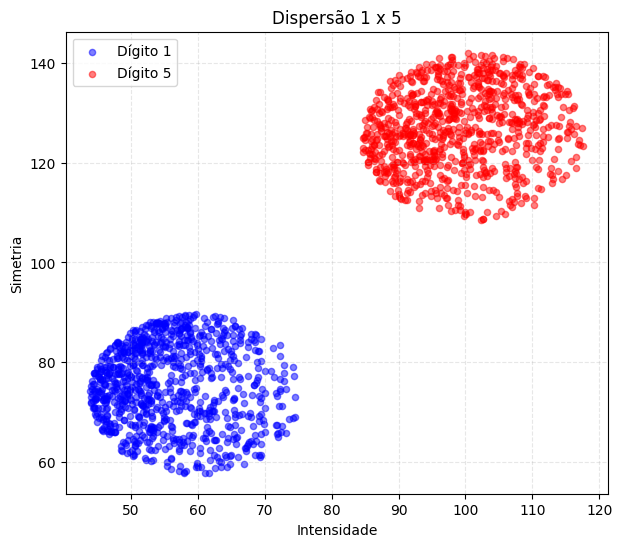

In [132]:
plt.figure(figsize=(7,6))

# Juntar os dados
dados_plot = pd.concat([train, test])

digito1 = dados_plot[dados_plot['label'] == digito_positivo]
digito2 = dados_plot[dados_plot['label'] == digito_negativo]

plt.scatter(digito1['intensidade'], digito1['simetria'], 
            color='blue', label=f'Dígito {digito_positivo}', alpha=0.5, s=20)
plt.scatter(digito2['intensidade'], digito2['simetria'], 
            color='red', label=f'Dígito {digito_negativo}', alpha=0.5, s=20)

plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title(f'Dispersão {digito_positivo} x {digito_negativo}')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

#### Encontrando os resultados dos modelos

- Preparando X e y (treino e teste)


In [133]:
X_train = train[['intensidade', 'simetria']].values
y_train_bin = np.where(train['label'] == digito_positivo, 1, -1)

X_test = test[['intensidade', 'simetria']].values
y_test_bin = np.where(test['label'] == digito_positivo, 1, -1)

- Normalizando

In [134]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

- Treinando os modelos

In [135]:
# Pocket perceptron
pocket = PocketPerceptron(max_iter=1000)
pocket.execute(X_train_s, y_train_bin)

# Perceptron manual
perc_manual = PerceptronManual(max_iter=1000)
perc_manual.execute(X_train_s, y_train_bin)

# Modelos da sklearn
modelo_perc = Perceptron(max_iter=1000, tol=1e-3, random_state=0)
modelo_log = LogisticRegression(max_iter=2000, random_state=0)
modelo_lr = LinearRegression()

modelo_perc.fit(X_train_s, y_train_bin)
modelo_log.fit(X_train_s, y_train_bin)
modelo_lr.fit(X_train_s, y_train_bin)

LinearRegression()

- Comparando os resultados no gráfico

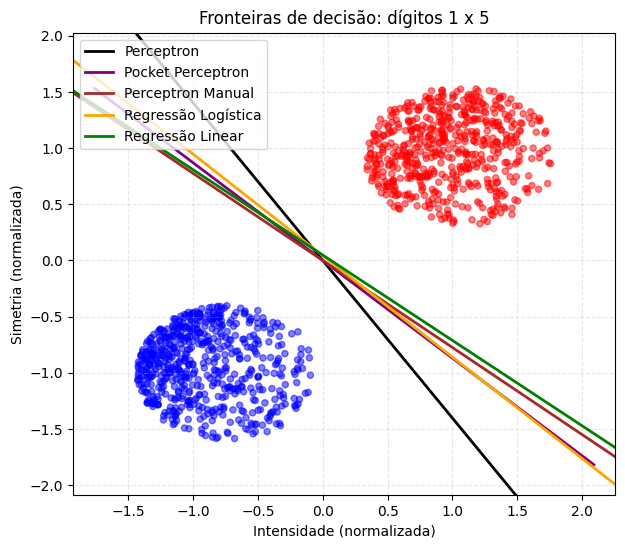

In [136]:
plt.figure(figsize=(7, 6))
plt.scatter(X_train_s[:, 0], X_train_s[:, 1],
            c=['blue' if v == 1 else 'red' for v in y_train_bin], alpha=0.5, s=20)

pad = 0.5
x_min, x_max = X_train_s[:, 0].min() - pad, X_train_s[:, 0].max() + pad
y_min, y_max = X_train_s[:, 1].min() - pad, X_train_s[:, 1].max() + pad

cores = {
    "Perceptron": "black",
    "Pocket Perceptron": "purple",
    "Perceptron Manual": "brown",
    "Regressão Linear": "green",
    "Regressão Logística": "orange"
}

def plot_reta_decisao_from_coef(coef, intercepto, color, label):
    x_vals = np.array(plt.gca().get_xlim())
    y_vals = -(intercepto + coef[0] * x_vals) / coef[1]
    plt.plot(x_vals, y_vals, color=color, label=label, linewidth=2)


plot_reta_decisao_from_coef(modelo_perc.coef_.ravel(), modelo_perc.intercept_[0], cores["Perceptron"], "Perceptron")
plot_reta_decisao_from_coef(pocket.w[1:], pocket.w[0], cores["Pocket Perceptron"], "Pocket Perceptron")
plot_reta_decisao_from_coef(perc_manual.w[1:], perc_manual.w[0], cores["Perceptron Manual"], "Perceptron Manual")
plot_reta_decisao_from_coef(modelo_log.coef_.ravel(), modelo_log.intercept_[0], cores["Regressão Logística"], "Regressão Logística")
plot_reta_decisao_from_coef(modelo_lr.coef_.ravel(), float(modelo_lr.intercept_), cores["Regressão Linear"], "Regressão Linear")

plt.xlabel("Intensidade (normalizada)")
plt.ylabel("Simetria (normalizada)")
plt.title(f"Fronteiras de decisão: dígitos {digito_positivo} x {digito_negativo}")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

#### Avaliando os dados de teste


==== Perceptron ====
              precision    recall  f1-score   support

           5       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583


==== PocketPerceptron ====
              precision    recall  f1-score   support

           5       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583


==== PerceptronManual ====
              precision    recall  f1-score   support

           5       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       

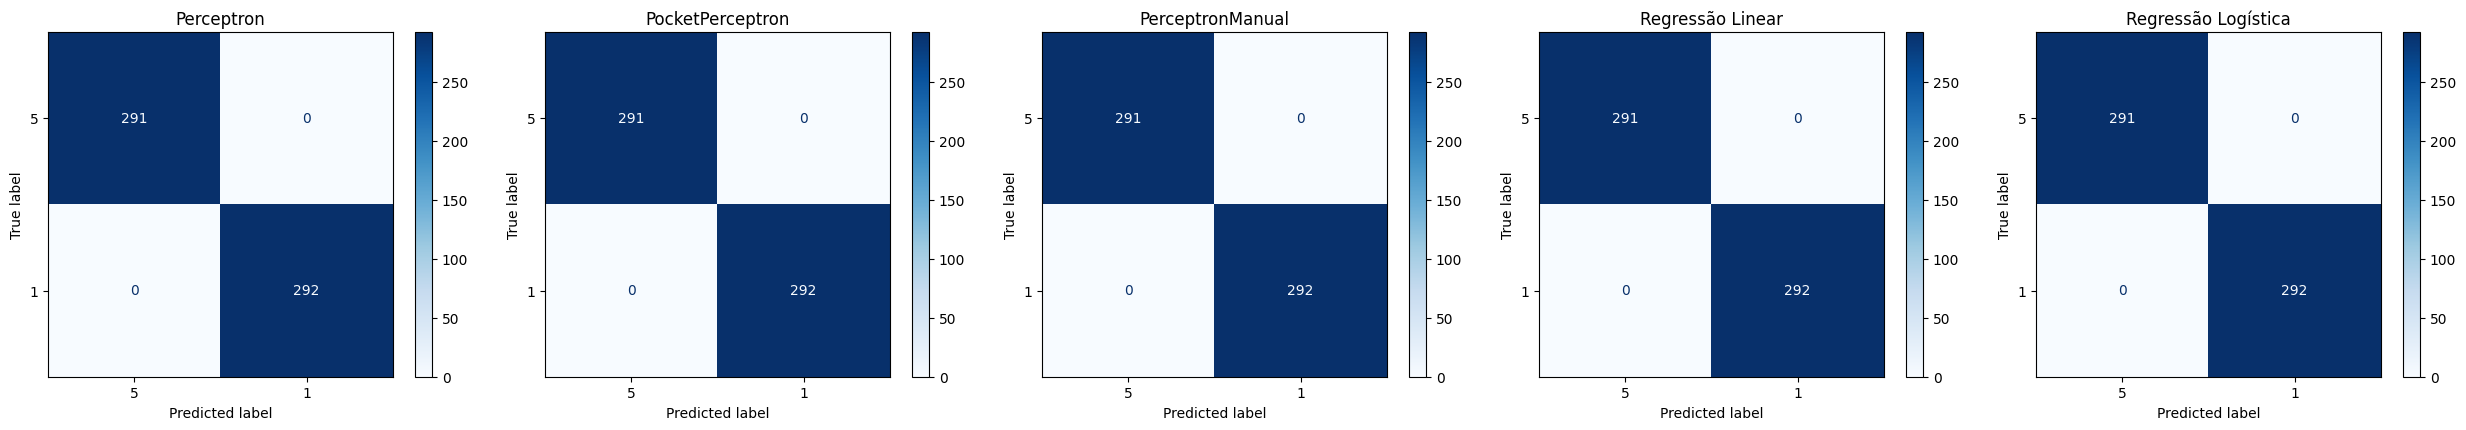

In [137]:
# Avaliação nos dados de teste (usando X_test_s) 
classificadores = {
    "Perceptron": modelo_perc,
    "PocketPerceptron": pocket,
    "PerceptronManual": perc_manual,
    "Regressão Linear": modelo_lr,
    "Regressão Logística": modelo_log,
}

# Pré-adiciona o bias para os modelos manuais
X_test_bias = np.c_[np.ones(X_test_s.shape[0]), X_test_s]

n_classificadores = len(classificadores)
fig, axes = plt.subplots(1, n_classificadores, figsize=(5*n_classificadores, 4))

for ax, (nome, modelo) in zip(axes, classificadores.items()):
    if nome in ["PocketPerceptron", "PerceptronManual"]:
        y_pred = np.array([modelo.h(xi) for xi in X_test_s])
    elif nome == "Regressão Linear":
        y_cont = modelo.predict(X_test_s)
        y_pred = np.where(y_cont >= 0, 1, -1)
    else:
        y_pred = modelo.predict(X_test_s)
    
    cm = confusion_matrix(y_test_bin, y_pred, labels=[-1, 1])
    print(f"\n==== {nome} ====")
    print(classification_report(y_test_bin, y_pred, target_names=[str(digito_negativo), str(digito_positivo)]))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[digito_negativo, digito_positivo])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f"{nome}")

plt.tight_layout()
plt.show()

